# Phase Coherence in Background 1/f 

Note: need to run function at bottom of notebook to re-run notebook.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind

from fooof import FOOOF

In [2]:
import mne
import neurodsp as ndsp

from mne.connectivity import spectral_connectivity
from neurodsp.sim import sim_brown_noise, sim_oscillator, sim_noisy_oscillator

In [9]:
# Data generation settings
s_freq = 1000    # hz
osc_freq = 5    # hz
sig_length = 5  # seconds  

n_epochs = 1
n_chs = 2
n_times = s_freq * sig_length

In [10]:
# Generate an oscillator
#  Sidenote: this doesn't feel like the ideal API for this function
n_samps_cycle = 1/osc_freq * s_freq
n_cycles = int(sig_length / (1/osc_freq))

osc_amp = 0.5
osc = osc_amp * sim_oscillator(n_samps_cycle, n_cycles)

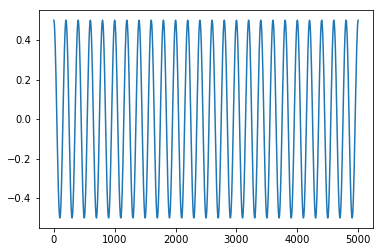

In [11]:
# Sanity check oscillator
plt.plot(osc)

In [12]:
# Collect oscillations together
oscs = np.zeros(shape=[n_epochs, n_chs, n_times])
oscs[0, 0, :] = osc
oscs[0, 1, :] = osc

In [13]:
# Sanity check coherence
con, freqs, times, nep, ntp = spectral_connectivity(oscs, 'coh', sfreq=s_freq, 
                                                    mode='multitaper',
                                                    fmin=4, fmax=6,
                                                    faverage=True, verbose=False)
print(con[1, 0])

[ 1.]


### Simulations

Simulates *n_chs* channels of data, *n_sims* times, in which each channel is given a slope value. 

Each channel gets a slope value, so length of slope values must == n_channels. 

Then calculates the phase coherence between the two channels. 

In [14]:
# Set up simulation
n_sims = 100  # Number of 'trials' of simulation
def run_sim(sls):
    
    outs = []

    for ind in range(n_sims):
        dat = np.zeros([n_epochs, n_chs, n_times])

        for ep_ind in range(n_epochs):

            # Generate some data
            for sl, ch_ind in zip(sls, range(n_chs)):
                dat[ep_ind, ch_ind, :] = powerlaw_psd_gaussian(sl, n_times)
            dat = dat + oscs

            # Calculate coherence - and collect output
            con, freqs, times, nep, ntp = spectral_connectivity(dat, 'coh', sfreq=s_freq, 
                                                                mode='multitaper',
                                                                fmin=4, fmax=6,
                                                                faverage=True, verbose=False)
            outs.append(con[1, 0])
    
    return outs

In [15]:
# Slope values for simulations
#  For these - run with two channels of data, so provide 2 slope values
sl1 = 1.75
sl2 = 2.00

In [16]:
# Run simulations
outs_11 = run_sim([sl1, sl1])
outs_12 = run_sim([sl1, sl2])
outs_22 = run_sim([sl2, sl2])

In [17]:
print('Same Slope 1:', np.mean(outs_11))
print('Diff Slope  :', np.mean(outs_12))
print('Same Slope 2:', np.mean(outs_22))

Same Slope 1: 0.738230690449
Diff Slope  : 0.759193207839
Same Slope 2: 0.780487223667


In [18]:
print('Same Slope 1 -> Diff Slope')
print('\t', *ttest_ind(outs_11, outs_12))
print('Same Slope 1 -> Same Slope 2')
print('\t', *ttest_ind(outs_11, outs_22))
print('Diff Slope -> Same Slope 2')
print('\t', *ttest_ind(outs_12, outs_22))

Same Slope 1 -> Diff Slope
	 [-2.6050435] [ 0.00988355]
Same Slope 1 -> Same Slope 2
	 [-5.38609797] [  2.02982342e-07]
Diff Slope -> Same Slope 2
	 [-2.93753448] [ 0.00370068]


In [ ]:
# print(np.mean(outs), np.std(outs))

# plt.plot(dat[0, 0, 0:1000])
# plt.plot(dat[0, 1, 0:1000])

In [ ]:
#fm = FOOOF(min_peak_amplitude=0.75, verbose=False)

In [ ]:
#fm.report(*ndsp.spectral.psd(dat[0, 0, :], s_freq), [1, 50])

In [ ]:
#fm.report(*ndsp.spectral.psd(dat[0, 1, :], s_freq), [1, 50])

In [ ]:
# Generate a couple of noisy oscillators
#out1 = sim_noisy_oscillator(5, n_times/100, 100, SNR=10)
#out2 = sim_noisy_oscillator(5, n_times/100, 100, SNR=10)

#plt.plot(out1[1:1000])
#plt.plot(out2)

# dat2 = np.zeros(shape=[1, 2, n_times])
# dat2[0, 0, :] = out1
# dat2[0, 1, :] = out1

In [ ]:
#con, freqs, times, nep, ntp = spectral_connectivity(dat2, 'plv', sfreq=10, fmin=4, fmax=6,
#                                                            faverage=True, verbose=False)

In [ ]:
# # Test: single sim

# dat = np.zeros([n_epochs, n_chs, n_times])

# for sl, ep_ind in zip(sls, range(n_epochs)):
#     for ch_ind in range(n_chs):
#         dat[ep_ind, ch_ind, :] = powerlaw_psd_gaussian(sl, n_times)
#         #dat[ep_ind, ch_ind, :] = sim_brown_noise(n_times)

# con, freqs, times, nep, ntp = spectral_connectivity(dat, 'coh', sfreq=100, fmin=4, fmax=8, faverage=True)

In [ ]:
#con

In [3]:
# Source: https://github.com/felixpatzelt/colorednoise
# Also: https://scicomp.stackexchange.com/questions/18987/algorithm-for-high-quality-1-f-noise
# Also: https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy

"""Generate colored noise."""

from numpy import concatenate, real, std, abs
from numpy.fft import ifft, fftfreq
from numpy.random import normal

def powerlaw_psd_gaussian(exponent, samples, fmin=0):
    """Gaussian (1/f)**beta noise.
    
    Based on the algorithm in:
    Timmer, J. and Koenig, M.: 
    On generating power law noise. 
    Astron. Astrophys. 300, 707-710 (1995)
    
    Normalised to unit variance
    
    Parameters:
    -----------
    
    exponent : float
        The power-spectrum of the generated noise is proportional to
        
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        
        Furthermore, the autocorrelation decays proportional to lag**-gamma 
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    
    samples : int
        number of samples to generate
    
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
        
    Returns
    -------
    out : array
        The samples.
    Examples:
    ---------
    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # frequencies (we asume a sample rate of one)
    f = fftfreq(samples)
    
    # scaling factor for all frequencies 
    ## though the fft for real signals is symmetric,
    ## the array with the results is not - take neg. half!
    s_scale = abs(concatenate([f[f<0], [f[-1]]]))
    ## low frequency cutoff?!?
    if fmin:
        ix = sum(s_scale>fmin)
        if ix < len(f):
            s_scale[ix:] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # scale random power + phase
    sr = s_scale * normal(size=len(s_scale))
    si = s_scale * normal(size=len(s_scale))
    if not (samples % 2): si[0] = si[0].real

    s = sr + 1J * si
    # this is complicated... because for odd sample numbers,
    ## there is one less positive freq than for even sample numbers
    s = concatenate([s[1-(samples % 2):][::-1], s[:-1].conj()])

    # time series
    y = ifft(s).real

    return y / std(y)

In [4]:
# Test noise generation
q1 = powerlaw_psd_gaussian(1.5, 1000)
q2 = powerlaw_psd_gaussian(2.5, 1000)

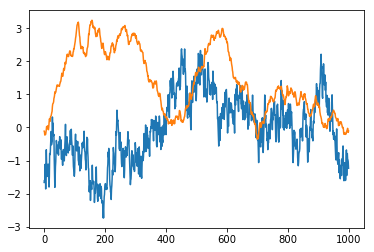

In [5]:
plt.plot(q1)
plt.plot(q2)

In [6]:
fm = FOOOF(min_peak_amplitude=5, verbose=0)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -0.8789, 1.5282                                          
                                                                                                  
                                       0 peaks were found:                                        
          

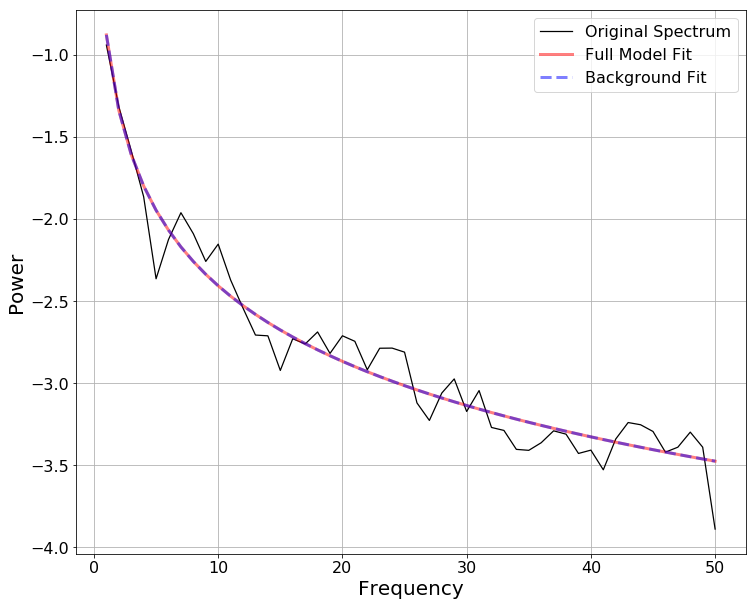

In [7]:
fm.report(*ndsp.spectral.psd(q1, 100))

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 50 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                         -1.1849, 2.4867                                          
                                                                                                  
                                       0 peaks were found:                                        
          

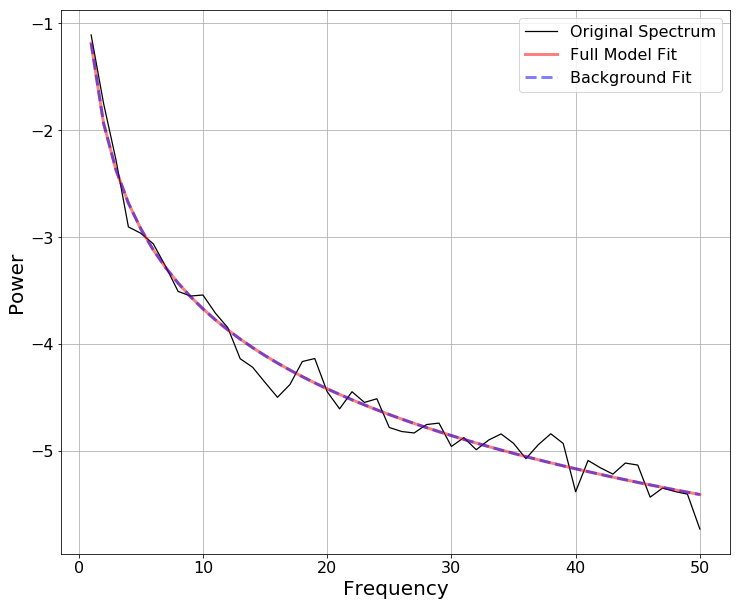

In [8]:
fm.report(*ndsp.spectral.psd(q2, 100))